In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [4]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 1],
    2: [3, 5],
    3: [2, 4]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

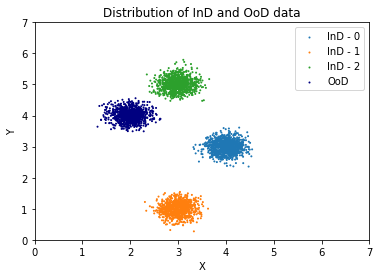

In [565]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

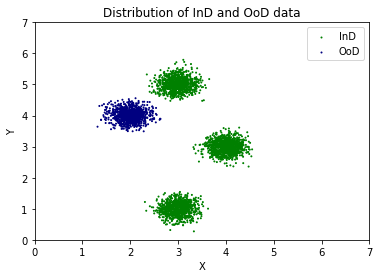

In [566]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [62]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  1%|          | 3/256 [00:00<00:23, 10.76it/s]

Epoch  # 1 | Tri loss: 1.2053                     | Tri accuracy: 0.2548
Epoch  # 1 | Val loss: 1.1774                     | Val accuracy: 0.3334


 21%|██▏       | 55/256 [00:02<00:08, 24.25it/s]

Epoch  # 51 | Tri loss: 0.0664                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0616                     | Val accuracy: 1.0


 40%|████      | 103/256 [00:04<00:06, 22.19it/s]

Epoch  # 101 | Tri loss: 0.0037                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0038                     | Val accuracy: 1.0


 60%|██████    | 154/256 [00:06<00:04, 24.19it/s]

Epoch  # 151 | Tri loss: 0.0013                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0014                     | Val accuracy: 1.0


 80%|████████  | 205/256 [00:09<00:02, 24.29it/s]

Epoch  # 201 | Tri loss: 0.0006                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.0007                     | Val accuracy: 1.0


 99%|█████████▉| 253/256 [00:11<00:00, 24.44it/s]

Epoch  # 251 | Tri loss: 0.0004                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0004                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:11<00:00, 22.74it/s]


#### Plot

torch.Size([10000, 3])


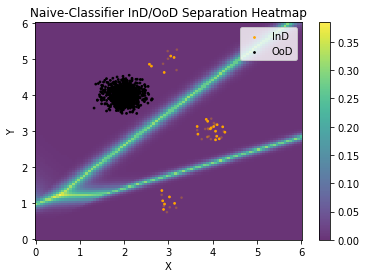

In [568]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [32]:
cri = torch.nn.NLLLoss()
a = torch.tensor([[0.99, 0.01]])
a = a.log()
print(cri(a, torch.tensor([1])))

tensor(4.6052)


In [67]:
from simulation import *
D_WOOD = DSIM(64)
# OOD data preparation
n_ood = 2
ood_bsz = 8
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH_0, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 1/256 [00:00<01:13,  3.45it/s]

Epoch  # 1 | Tri loss: 0.944                     | Tri accuracy: 0.7204
tensor(0.2532, grad_fn=<WassersteinBackward>)
Epoch  # 1 | Val loss: 0.8146                     | Val accuracy: 0.9779


  4%|▍         | 11/256 [00:03<01:23,  2.95it/s]

Epoch  # 11 | Tri loss: 0.0481                     | Tri accuracy: 1.0
tensor(0.0023, grad_fn=<WassersteinBackward>)
Epoch  # 11 | Val loss: 0.0435                     | Val accuracy: 1.0


  8%|▊         | 21/256 [00:07<01:25,  2.73it/s]

Epoch  # 21 | Tri loss: 0.0103                     | Tri accuracy: 1.0
tensor(0.0001, grad_fn=<WassersteinBackward>)
Epoch  # 21 | Val loss: 0.0098                     | Val accuracy: 1.0


 12%|█▏        | 31/256 [00:10<01:15,  2.97it/s]

Epoch  # 31 | Tri loss: 0.0039                     | Tri accuracy: 1.0
tensor(1.6697e-05, grad_fn=<WassersteinBackward>)
Epoch  # 31 | Val loss: 0.0038                     | Val accuracy: 1.0


 16%|█▌        | 41/256 [00:13<01:03,  3.37it/s]

Epoch  # 41 | Tri loss: 0.002                     | Tri accuracy: 1.0
tensor(4.9302e-06, grad_fn=<WassersteinBackward>)
Epoch  # 41 | Val loss: 0.002                     | Val accuracy: 1.0


 20%|█▉        | 51/256 [00:16<01:05,  3.13it/s]

Epoch  # 51 | Tri loss: 0.0013                     | Tri accuracy: 1.0
tensor(1.8792e-06, grad_fn=<WassersteinBackward>)
Epoch  # 51 | Val loss: 0.0013                     | Val accuracy: 1.0


 24%|██▍       | 61/256 [00:19<00:52,  3.71it/s]

Epoch  # 61 | Tri loss: 0.0008                     | Tri accuracy: 1.0
tensor(8.8106e-07, grad_fn=<WassersteinBackward>)
Epoch  # 61 | Val loss: 0.0008                     | Val accuracy: 1.0


 28%|██▊       | 71/256 [00:22<00:50,  3.66it/s]

Epoch  # 71 | Tri loss: 0.0005                     | Tri accuracy: 1.0
tensor(4.3250e-07, grad_fn=<WassersteinBackward>)
Epoch  # 71 | Val loss: 0.0005                     | Val accuracy: 1.0


 32%|███▏      | 81/256 [00:24<00:50,  3.48it/s]

Epoch  # 81 | Tri loss: 0.0003                     | Tri accuracy: 1.0
tensor(2.6993e-07, grad_fn=<WassersteinBackward>)
Epoch  # 81 | Val loss: 0.0004                     | Val accuracy: 1.0


 36%|███▌      | 91/256 [00:27<00:45,  3.65it/s]

Epoch  # 91 | Tri loss: 0.0003                     | Tri accuracy: 1.0
tensor(1.4746e-07, grad_fn=<WassersteinBackward>)
Epoch  # 91 | Val loss: 0.0003                     | Val accuracy: 1.0


 39%|███▉      | 101/256 [00:30<00:42,  3.62it/s]

Epoch  # 101 | Tri loss: 0.0002                     | Tri accuracy: 1.0
tensor(6.3550e-08, grad_fn=<WassersteinBackward>)
Epoch  # 101 | Val loss: 0.0002                     | Val accuracy: 1.0


 43%|████▎     | 111/256 [00:33<00:39,  3.66it/s]

Epoch  # 111 | Tri loss: 0.0002                     | Tri accuracy: 1.0
tensor(3.1552e-08, grad_fn=<WassersteinBackward>)
Epoch  # 111 | Val loss: 0.0002                     | Val accuracy: 1.0


 47%|████▋     | 121/256 [00:35<00:33,  3.97it/s]

Epoch  # 121 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(5.3614e-08, grad_fn=<WassersteinBackward>)
Epoch  # 121 | Val loss: 0.0001                     | Val accuracy: 1.0


 51%|█████     | 131/256 [00:38<00:31,  4.01it/s]

Epoch  # 131 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(5.8343e-08, grad_fn=<WassersteinBackward>)
Epoch  # 131 | Val loss: 0.0001                     | Val accuracy: 1.0


 55%|█████▌    | 141/256 [00:40<00:29,  3.84it/s]

Epoch  # 141 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(-1.7522e-08, grad_fn=<WassersteinBackward>)
Epoch  # 141 | Val loss: 0.0001                     | Val accuracy: 1.0


 59%|█████▉    | 151/256 [00:43<00:27,  3.88it/s]

Epoch  # 151 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(4.3929e-10, grad_fn=<WassersteinBackward>)
Epoch  # 151 | Val loss: 0.0001                     | Val accuracy: 1.0


 63%|██████▎   | 161/256 [00:45<00:24,  3.94it/s]

Epoch  # 161 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(2.3250e-08, grad_fn=<WassersteinBackward>)
Epoch  # 161 | Val loss: 0.0001                     | Val accuracy: 1.0


 67%|██████▋   | 171/256 [00:48<00:21,  3.92it/s]

Epoch  # 171 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(1.7185e-08, grad_fn=<WassersteinBackward>)
Epoch  # 171 | Val loss: 0.0001                     | Val accuracy: 1.0


 71%|███████   | 181/256 [00:51<00:21,  3.50it/s]

Epoch  # 181 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(1.3263e-08, grad_fn=<WassersteinBackward>)
Epoch  # 181 | Val loss: 0.0001                     | Val accuracy: 1.0


 75%|███████▍  | 191/256 [00:53<00:18,  3.46it/s]

Epoch  # 191 | Tri loss: 0.0001                     | Tri accuracy: 1.0
tensor(1.0154e-08, grad_fn=<WassersteinBackward>)
Epoch  # 191 | Val loss: 0.0001                     | Val accuracy: 1.0


 79%|███████▊  | 201/256 [00:56<00:17,  3.17it/s]

Epoch  # 201 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(8.0188e-09, grad_fn=<WassersteinBackward>)
Epoch  # 201 | Val loss: 0.0001                     | Val accuracy: 1.0


 82%|████████▏ | 211/256 [00:59<00:11,  3.86it/s]

Epoch  # 211 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(6.1983e-09, grad_fn=<WassersteinBackward>)
Epoch  # 211 | Val loss: 0.0                     | Val accuracy: 1.0


 86%|████████▋ | 221/256 [01:02<00:08,  3.96it/s]

Epoch  # 221 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(4.9357e-09, grad_fn=<WassersteinBackward>)
Epoch  # 221 | Val loss: 0.0                     | Val accuracy: 1.0


 90%|█████████ | 231/256 [01:04<00:06,  3.95it/s]

Epoch  # 231 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(3.9892e-09, grad_fn=<WassersteinBackward>)
Epoch  # 231 | Val loss: 0.0                     | Val accuracy: 1.0


 94%|█████████▍| 241/256 [01:07<00:03,  3.95it/s]

Epoch  # 241 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(3.2599e-09, grad_fn=<WassersteinBackward>)
Epoch  # 241 | Val loss: 0.0                     | Val accuracy: 1.0


 98%|█████████▊| 251/256 [01:09<00:01,  3.84it/s]

Epoch  # 251 | Tri loss: 0.0                     | Tri accuracy: 1.0
tensor(2.6467e-09, grad_fn=<WassersteinBackward>)
Epoch  # 251 | Val loss: 0.0                     | Val accuracy: 1.0


100%|██████████| 256/256 [01:11<00:00,  3.59it/s]


In [68]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 0.210999995470047
0.99: 0.020999999716877937
0.999: 0.004000000189989805


1.1123327189125789e-05

### OOD GAN Training

In [72]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64)
G_GAN = GSIM(64)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 0.1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/256 [00:00<?, ?it/s]

Step: 0    | D:  1.1835 | CE:  1.1939 | W_OoD:  0.1393 | W_z:  0.3562 | G: -0.0036 | W_z:  0.3575 | dist: 3.2498
Step: 10   | D:  1.0813 | CE:  1.0936 | W_OoD:  0.1593 | W_z:  0.3660 | G: -0.0037 | W_z:  0.3662 | dist: 3.2756


  0%|          | 1/256 [00:40<2:50:21, 40.08s/it]

Epoch  # 1 | Val accuracy: 0.3337
Step: 8    | D:  1.0594 | CE:  1.0740 | W_OoD:  0.1830 | W_z:  0.3670 | G: -0.0037 | W_z:  0.3664 | dist: 3.0311


  1%|          | 2/256 [01:17<2:42:50, 38.47s/it]

Step: 6    | D:  1.0029 | CE:  1.0201 | W_OoD:  0.2086 | W_z:  0.3619 | G: -0.0036 | W_z:  0.3613 | dist: 2.8048


  1%|          | 3/256 [01:55<2:42:17, 38.49s/it]

Step: 4    | D:  0.9481 | CE:  0.9678 | W_OoD:  0.2337 | W_z:  0.3602 | G: -0.0036 | W_z:  0.3599 | dist: 2.5667


  2%|▏         | 4/256 [02:35<2:43:17, 38.88s/it]

Step: 2    | D:  0.9311 | CE:  0.9531 | W_OoD:  0.2570 | W_z:  0.3640 | G: -0.0036 | W_z:  0.3646 | dist: 2.2586


  2%|▏         | 5/256 [03:14<2:43:19, 39.04s/it]

Step: 0    | D:  0.9209 | CE:  0.9450 | W_OoD:  0.2778 | W_z:  0.3765 | G: -0.0038 | W_z:  0.3786 | dist: 1.8537
Step: 10   | D:  0.8911 | CE:  0.9163 | W_OoD:  0.2902 | W_z:  0.3814 | G: -0.0038 | W_z:  0.3810 | dist: 1.6534


  2%|▏         | 6/256 [03:55<2:44:59, 39.60s/it]

Epoch  # 6 | Val accuracy: 0.6665
Step: 8    | D:  0.8718 | CE:  0.8973 | W_OoD:  0.2936 | W_z:  0.3815 | G: -0.0038 | W_z:  0.3826 | dist: 1.5671


  3%|▎         | 7/256 [04:32<2:40:25, 38.66s/it]

Step: 6    | D:  0.8722 | CE:  0.8975 | W_OoD:  0.2919 | W_z:  0.3826 | G: -0.0038 | W_z:  0.3827 | dist: 1.5507


  3%|▎         | 8/256 [05:16<2:47:34, 40.54s/it]

Step: 4    | D:  0.8554 | CE:  0.8801 | W_OoD:  0.2858 | W_z:  0.3831 | G: -0.0038 | W_z:  0.3826 | dist: 1.5101


  4%|▎         | 9/256 [05:57<2:47:16, 40.63s/it]

### Plot

#### Plot Naive Classifier

In [63]:
m, n_ind, n_ood = 300, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([90000, 3])


In [64]:
threshold =calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold

0.99: 0.003000000026077032


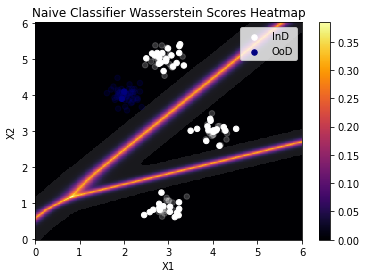

In [65]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
n_ind, n_ood = 50, 50, 
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"Naive Classifier Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_naive.jpg", dpi=1000)

#### Plot WOOD

In [69]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


0.99: 0.020999999716877937


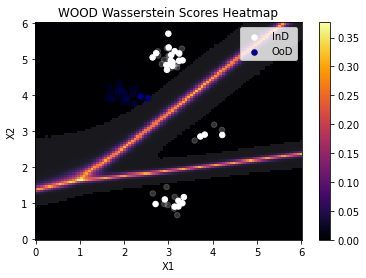

In [70]:
threshold =calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si > threshold
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"WOOD Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example_wood.jpg", dpi=1000)

#### Plot GAN

In [57]:
m, n_ind, n_ood = 100, 25, 25
xi = np.linspace(0, 6, m, endpoint=True)
yi = np.linspace(0, 6, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi_gan = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi_gan.shape)
si_gan = ood_wass_loss(zi_gan)

torch.Size([10000, 3])


In [58]:
threshold =calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)
mask = si_gan > threshold

0.99: 1.0


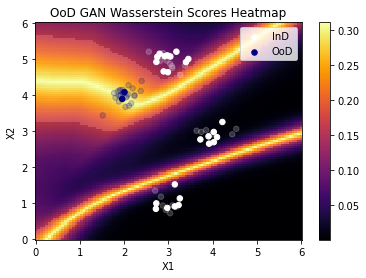

In [59]:
# plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
plt.pcolormesh(xi, yi, si_gan.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
plt.colorbar()
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto',cmap='gray', alpha=0.1)
# InD and OoD
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ind, replace=False)
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='white', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.title(f"OoD GAN Wasserstein Scores Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.savefig(f"simulation_log/plot/example.jpg", dpi=1000)

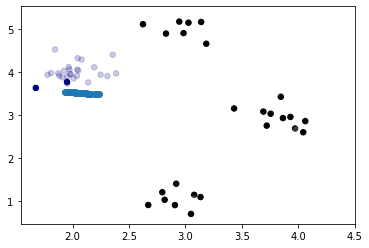

In [38]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')